In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read file

In [2]:
data = pd.read_csv("./raw_data.csv")

** check head, info, describe of the data**

In [3]:
data.head()

,ID,商品名稱,商品狀態,商品類型,品牌名稱,價格,有無運費,商品描述
0,417400,White Gauze Asymmetrical​ Skirt Jrs Lrg,3,Women/Skirts/Mini,A. Byer,9.0$,O,Super fun asymmetrical hem gauze skirt. White ...
1,123639,Kat Von D Sinner Eau De Parfum 1.7fl Ox,2,Beauty/Fragrance/Women,Kat Von D,43.0$,X,This is a new bottle that has no box full with...
2,698012,NYX HYDRA TOUCH PRIMER,1,Beauty/Makeup/Face,NYX,10.0$,O,NEW - CLOSED HTP01 PRIMER / BASE *Prebase* 30 g
3,1402513,"BUNDLE, DONT BUY",1,Vintage & Collectibles/Antique/Collectibles,NaN,100.0$,O,Smells like peaches. no defects
4,669773,NWT SHEEX men's sleep shorts,1,Men/Athletic Apparel/Shorts,NaN,29.0$,X,Very nice. Retails for [rm]


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
ID      50000 non-null int64
商品名稱    50000 non-null object
商品狀態    50000 non-null int64
商品類型    49793 non-null object
品牌名稱    28741 non-null object
價格      50000 non-null object
有無運費    50000 non-null object
商品描述    50000 non-null object
dtypes: int64(2), object(6)
memory usage: 3.1+ MB


In [5]:
data.describe()

,ID,商品狀態
count,5.000000e+04,50000.000000
mean,7.403384e+05,1.906160
std,4.284171e+05,0.902513
min,5.700000e+01,1.000000
25%,3.686725e+05,1.000000
50%,7.389115e+05,2.000000
75%,1.112281e+06,3.000000
max,1.482507e+06,5.000000


Just for our convenience, rename the columns

In [6]:
data = data.rename(index=str, columns={'ID':'ID', '商品名稱':'name', '商品狀態':'status', '商品類型':'category', '品牌名稱':'brand'
                                , '價格':'price', '有無運費':'deliveryfee', '商品描述':'discription'})

# Data Preprocessing

** convert price into numeric**

In [7]:
data['price'] = pd.to_numeric(data['price'].str.replace('$',''))

** extract sub categories**

In [8]:
data[['main_cat','sub_cat','subsub_cat','a1','a2']] = data['category'].str.split("/",expand=True)

**Drop irrelevant variables**
---
- ID
- name
- (trivial subcategory) a1,a2
- description
(We skip text analysis due to the time limit)

In [9]:
data = data.drop(['ID','a1','a2','discription','name','category'], axis = 1) 

** Fill missing value**
---
- Numeric: 0
- Category: None

In [10]:
data = data.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('None'))

**(Clean data)**
---

In [11]:
data.head()

,status,brand,price,deliveryfee,main_cat,sub_cat,subsub_cat
0,3,A. Byer,9.0,O,Women,Skirts,Mini
1,2,Kat Von D,43.0,X,Beauty,Fragrance,Women
2,1,NYX,10.0,O,Beauty,Makeup,Face
3,1,None,100.0,O,Vintage & Collectibles,Antique,Collectibles
4,1,None,29.0,X,Men,Athletic Apparel,Shorts


# EDA

**Univariate plots**
---
(Export into files)

In [158]:
def f(x): 
    if x.dtype.kind in 'biufc':
        sns.distplot(x)
    else:
        sns.countplot(x,order =x.value_counts().index)
    plt.savefig(x.name)
    plt.clf()
data.apply(f,reduce=False)
# reduce make each col remain same dtype. Without this option, apply would cast all col into Object

status         None
brand          None
price          None
deliveryfee    None
main_cat       None
sub_cat        None
subsub_cat     None
dtype: object

** Target **

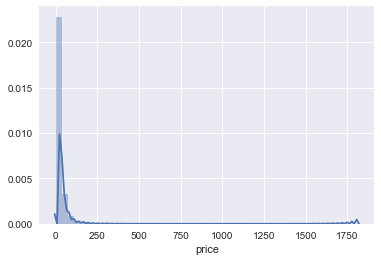

In [159]:
sns.distplot(data['price'])
# What a lonnnnng tail

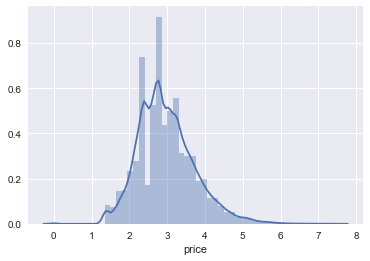

In [160]:
#After log transform
sns.distplot(np.log(data['price']+1))

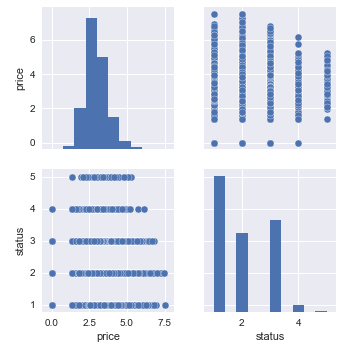

In [161]:
#status
sns.pairplot(pd.concat([np.log(data['price']+1),data['status']],axis = 1))

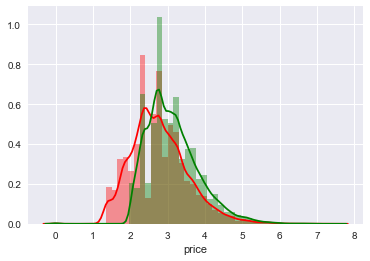

In [162]:
# dilivery fee
sns.distplot(np.log(data[data['deliveryfee']=='O']['price']+1),color = 'red')
sns.distplot(np.log(data[data['deliveryfee']=='X']['price']+1),color = 'green')
#seems that higher price comes without delivery fee

# Modeling

** Transform categorical variables **
---
Since most algorithms takes only numeric types, we transform
- categorical: dummies(one-hot encodeing)
- ordinal: integer

In [14]:
cat_list = ['status','brand','main_cat','sub_cat','subsub_cat','deliveryfee']
for i in cat_list:
    data = pd.concat([data, pd.get_dummies(data[i],prefix=i)], axis=1)
    data = data.drop(i,axis = 1)

In [15]:
data.head()

,price,status_1,status_2,status_3,status_4,status_5,brand_!iT Jeans,brand_% Pure,brand_21men,brand_3.1 Phillip Lim,brand_3M®,brand_47 Brand,brand_525 America,brand_5th & Ocean,brand_7 For All Mankind®,brand_A Bathing Ape,brand_A Pea In The Pod,brand_A Plus Child Supply,brand_A. Byer,brand_A.P.C.,brand_A/X Armani Exchange,brand_AB Studio,brand_ADAM,brand_AG Adriano Goldschmied,brand_AGB,brand_AKIRA,brand_ALDO,brand_ALEX AND ANI,brand_ALO Yoga,brand_AMD,brand_ART,brand_ASICS,brand_ASOS,brand_ASUS,brand_AT-A-GLANCE,brand_Abbott,brand_Abercrombie & Fitch,brand_Abu Garcia,brand_Acacia Swimwear,brand_Accessory Workshop,brand_Acer,brand_Active,brand_Activision,brand_Adidas,brand_Adrianna Papell,brand_Adrienne Landau,brand_Adrienne Vittadini,brand_Advanced Healthcare Distributors,brand_Advent,brand_Aeropostale,brand_Aerosoles,brand_Affliction,brand_Air Force,brand_Air Jordan,brand_Air Wick,brand_Akademiks,brand_Alberto Makali,brand_Alcon,brand_Alegro,brand_Alexander McQueen,brand_Alexander Wang,brand_Alexandra de Markoff,brand_Alfani,brand_Alfred Angelo,brand_Alfred Dunner,brand_All,brand_All American,brand_AllSaints,brand_Allure,brand_Almay,brand_Almost Famous,brand_Alo,brand_Alpine Design,brand_Alpinestars,brand_Alstyle Apparel,brand_Altar'd State,brand_Altec Lansing,brand_Always,brand_Amazon,brand_AmazonBasics,brand_Ambiance Apparel,brand_Ameda,brand_American Apparel,brand_American Boy & Girl,brand_American Eagle,brand_American Fighter,brand_American Girl ®,brand_American Rag,brand_Anastasia Beverly Hills,brand_Anchor Hocking,brand_Andrew Christian,brand_Angels,brand_Angie,brand_Ann Taylor,brand_Ann Taylor LOFT,brand_Anna Sui,brand_Anne Cole,brand_Anne Klein,brand_Anne Michelle,brand_Anthropologie,brand_Antonio Melani,brand_Anvil,brand_Apple,brand_Apt.,brand_Apt. 9,brand_Aqueon,brand_Arbonne,brand_Arc'teryx,brand_Ardell,brand_Arden B,brand_Ariat,brand_Arizona,brand_Arizona Jean Company,brand_Arm & Hammer,brand_Armani,brand_Aroma,brand_As Seen on TV,brand_As U Wish,brand_Ashley Stewart,brand_Assets,brand_Athleta,brand_Athletech,brand_Athletic Works,brand_Atlantis Toy and Hobby,brand_Audio-Technica,brand_Aveda,brand_Aveeno,brand_Avent,brand_Avenue,brand_Avery,brand_Avia,brand_Avirex,brand_Avon,brand_A|X Armani Exchange,brand_Aéropostale,brand_B Darlin,brand_BB,brand_BB Dakota,brand_BCBG,brand_BCBGMAXAZRIA,brand_BCBGeneration,brand_BCBGirls,brand_BDG,brand_BISOU BISOU,brand_BKE,brand_BLANQI,brand_Babies R Us,brand_Babies R Us Plush,brand_Baby Brezza,brand_Baby Bullet,brand_Baby Delight,brand_Baby Einstein,brand_Baby Phat,brand_Baby connection,brand_BabyBjorn,brand_Back to Basics,brand_Badgley Mischka,brand_Bakers,brand_Ball,brand_Bally,brand_Balmain,brand_Bamboobies,brand_Banana Republic,brand_Bandai,brand_Bandolino,brand_Bape,brand_Bar Lll,brand_Barbie,brand_Barbour,brand_Bare Escentuals,brand_Barnett Crossbows,brand_Bass,brand_Bath & Body Works,brand_BaubleBar,brand_Bay Island,brand_BeBop,brand_Beats,brand_Beats by Dr. Dre,brand_BeautiControl,brand_Bebe,brand_Bebe Au Lait,brand_BebeSounds,brand_Beechnut,brand_Belkin,brand_Bella,brand_Bella Cucina,brand_Belly Bandit®,brand_Ben Nye,brand_Ben Sherman,brand_Bench,brand_Benefit,brand_Betsey Johnson,brand_Bettie Page,brand_Betty Crocker,brand_Beverly Hills Polo Club,brand_Beyond Yoga,brand_Bic,brand_Big Star,brand_Billabong,brand_Biore,brand_Bioworld,brand_Birkenstock,brand_Black & Decker,brand_Black Scale,brand_Blank NYC,brand_Blendtec,brand_Blinc,brand_Blip Toys,brand_Blizzard,brand_Blooming Bath,brand_Blue Asphalt,brand_Blue Life,brand_Blue Microphones,brand_Bobbi Brown,brand_Bobbie Brooks,brand_Bobeau,brand_Body Central,brand_Body Glove,brand_Boho Chic,brand_Bongo,brand_Bonne Bell,brand_Boo!,brand_Boohoo,brand_Boohoo Petite,brand_Boon,brand_Boots,brand_Boppy,brand_Born,brand_Bose,brand_Boston Proper,brand_Brahmin,brand_Brandy Melville,brand_Braun,brand_Bravado,brand_Bravado Designs,brand_BrazilRoxx,brand_BreathableBaby,brand_Breyer,brand_Bright Starts,brand_Brighton,brand_Brine,brand_

** train test split**
---

In [14]:

from sklearn.model_selection import train_test_split
X = data.drop('price', axis = 1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 100)

** Regression Tree**
---

In [15]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X, y)

In [16]:
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)

In [17]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 10.0046918914
MSE: 870.295033275
RMSE: 29.500763266


** Seems we have a (decent?) MAE and a huge MSE. This might imply that there are some** ****outliers****
**that suffer huge prediction error**

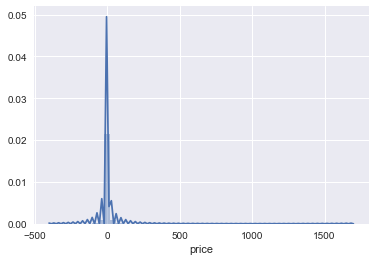

In [18]:
#residual plot
sns.distplot((y_test-y_pred),bins=50)

**XGBoost**
---

In [19]:
import xgboost
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [20]:
xgb.score(X_test, y_test)
y_pred = xgb.predict(X_test)

In [21]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 16.3495899309
MSE: 1715.05543213
RMSE: 41.4132277435


** Worse outcome **

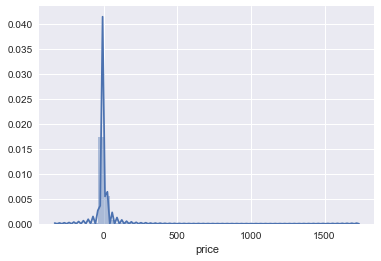

In [22]:
#residual plot
sns.distplot((y_test-y_pred),bins=50)

# Modeling (predict log price)

** Let's try to use log price as target **

In [16]:
# train test split
from sklearn.model_selection import train_test_split
X = data.drop('price', axis = 1)
y = np.log(data['price']+1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 100)

** Regression Tree**
---

In [17]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X, y)

In [18]:
clf.score(X_test, y_test)
y_pred = np.exp(clf.predict(X_test))-1

In [20]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 20.3510376774
MSE: 1361.78889473
RMSE: 36.9024239682


**worse**

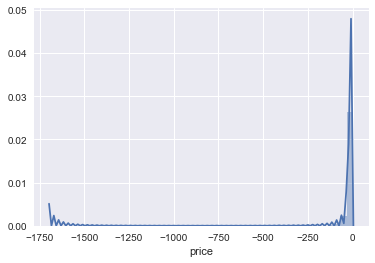

In [21]:
#residual plot shows under predict
sns.distplot((y_test-y_pred),bins=50)

# Future works
---
-	Outlier removal
-	Parameter tuning
-	Text mining on good names and descriptions


# final

In [24]:
clf_f = tree.DecisionTreeRegressor()
clf_f = clf.fit(data.drop('price',axis = 1),data['price'])
y_f = clf_f.predict(data.drop('price',axis = 1))


In [26]:
pd.DataFrame(y_f).to_csv("./predict.csv")